In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import optuna
import catboost as cb
from sklearn.metrics import f1_score, multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils import class_weight

from sklearn.preprocessing import MultiLabelBinarizer

In [17]:
train_df = pd.read_csv("./data/preprocessed_train_with_text.csv")
train_df.head()

,title,description,action,adventure,animation,biography,comedy,crime,documentary,drama,...,label_musical,label_mystery,label_romance,label_sci_fi,label_short,label_sport,label_superhero,label_thriller,label_war,label_western
0,The Expanse,"In the 24th century, a group of humans untangl...",0,0,0,0,0,0,0,1,...,-4.705538,-1.740246,-2.477686,-2.725520,-1.630180,-4.451623,-4.460684,-1.920984,-3.935638,-4.253859
1,Night Stalker: The Hunt for a Serial Killer,This limited docu-series tells the true story ...,0,0,0,0,0,1,1,0,...,-4.714048,-1.718692,-2.598201,-2.736385,-1.566298,-4.479524,-4.416039,-1.896247,-4.000548,-4.240667
2,Hannah Montana: The Movie,As Hannah Montana's popularity begins to take ...,0,0,0,0,1,0,0,1,...,-4.655421,-1.828271,-2.473522,-2.792503,-1.582655,-4.454690,-4.509440,-2.018930,-3.998400,-4.271553
3,London Kills,Drama series following the detectives of an el...,0,0,0,0,0,1,0,1,...,-4.854730,-1.622334,-2.541588,-2.723159,-1.720303,-4.402906,-4.464204,-1.800379,-3.804892,-4.209084
4,Women's Prison,A sadistic prison warden takes out her sexual ...,0,0,0,0,0,1,0,1,...,-4.846175,-1.601429,-2.501574,-2.744615,-1.736988,-4.431142,-4.486163,-1.793381,-3.839825,-4.254248


In [18]:
test_df = pd.read_csv("./data/preprocessed_test_with_text.csv")
test_df.head()

,title,description,action,adventure,animation,biography,comedy,crime,documentary,drama,...,label_musical,label_mystery,label_romance,label_sci_fi,label_short,label_sport,label_superhero,label_thriller,label_war,label_western
0,Marie Antoinette,The retelling of France's iconic but ill-fated...,0,0,0,1,0,0,0,1,...,-4.827373,-1.691259,-2.431045,-2.780620,-1.755320,-4.395231,-4.530811,-1.891145,-3.789797,-4.247899
1,An American Crime,The true story of suburban housewife Gertrude ...,0,0,0,1,0,1,0,1,...,-4.733858,-1.746305,-2.521195,-2.763253,-1.640083,-4.452400,-4.487211,-1.924237,-3.964722,-4.264340
2,Crime Wave,Reformed parolee Steve Lacey is caught in the ...,0,0,0,0,0,1,0,1,...,-4.962561,-1.537998,-2.685872,-2.766246,-1.792353,-4.442873,-4.486105,-1.705693,-3.867658,-4.207180
3,Bad News Bears,A grizzled little league coach tries to turn h...,0,0,0,0,1,0,0,0,...,-4.801690,-1.772772,-2.562803,-2.791305,-1.636546,-4.374332,-4.500286,-1.955580,-3.944787,-4.194254
4,The Texas Chain Saw Massacre,Five friends head out to rural Texas to visit ...,0,0,0,0,0,0,0,0,...,-4.737229,-1.725573,-2.575740,-2.755524,-1.617822,-4.475309,-4.456771,-1.901333,-3.962187,-4.200102


In [19]:
CATEGORIES = ["action", "adventure", "animation", "biography", "comedy", "crime", "documentary", "drama", "family",
              "fantasy", "film_noir", "history", "horror", "music", "musical", "mystery", "romance", "sci_fi",
              "short", "sport", "superhero", "thriller", "war", "western"]

In [20]:
len(train_df)

3332

In [21]:
len(test_df)

834

# Show barchart categories

In [22]:
cunt_classes = train_df[CATEGORIES].sum() + test_df[CATEGORIES].sum()

<AxesSubplot: >

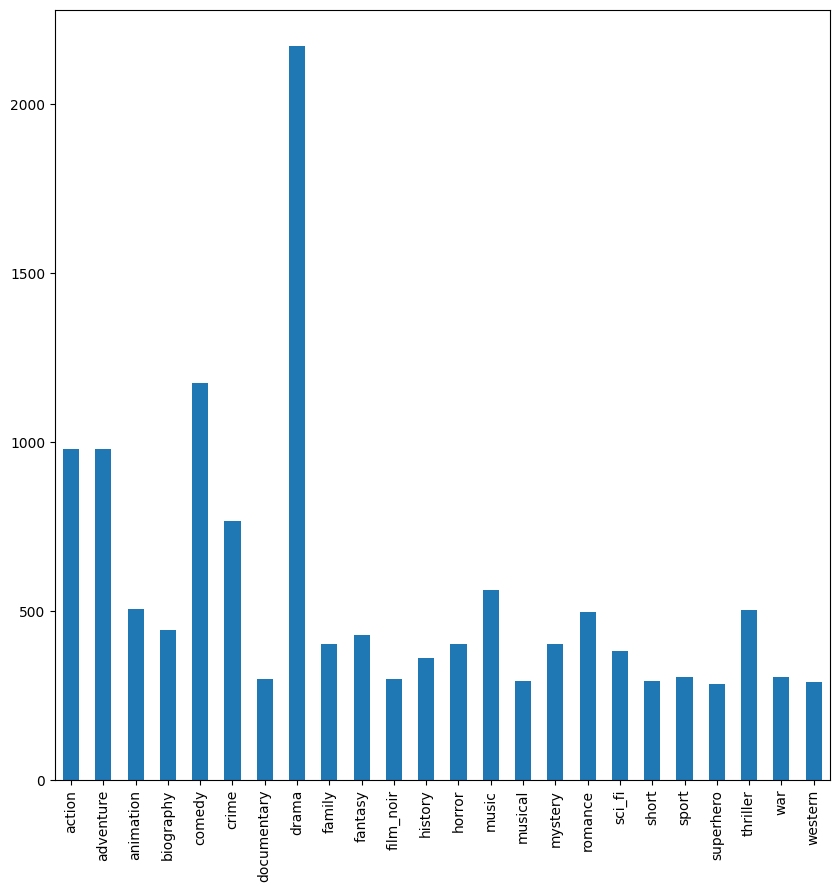

In [23]:
cunt_classes.plot.bar(figsize=(10,10))

# Now we have clean test_df and train_df

In [24]:
LABEL_FEATURES = [f"label_{elem}" for elem in CATEGORIES]
DESCRIPTION_FEATURES = [f"descr_{elem}" for elem in CATEGORIES]

train_x = train_df[LABEL_FEATURES + DESCRIPTION_FEATURES]
train_y = train_df[CATEGORIES]

test_x = test_df[LABEL_FEATURES + DESCRIPTION_FEATURES]
test_y = test_df[CATEGORIES]

In [25]:
train_x.head()

,label_action,label_adventure,label_animation,label_biography,label_comedy,label_crime,label_documentary,label_drama,label_family,label_fantasy,...,descr_musical,descr_mystery,descr_romance,descr_sci_fi,descr_short,descr_sport,descr_superhero,descr_thriller,descr_war,descr_western
0,-3.526231,-3.846611,-3.998016,-2.797113,-1.745880,-2.238662,-0.560584,-0.863482,-3.707271,-2.729316,...,-5.492369,-3.022171,-3.279222,-2.158490,-0.207564,-3.365426,-4.046495,-3.381069,-4.921396,-4.227958
1,-3.521924,-3.849661,-3.936619,-2.912678,-1.718511,-2.161377,-0.455733,-1.043046,-3.692162,-2.703327,...,-5.973933,-2.930260,-4.064121,-2.678376,-0.406930,-3.766007,-4.018946,-3.183953,-5.060203,-4.233124
2,-3.613245,-3.875621,-3.991794,-2.839758,-1.666617,-2.277126,-0.496114,-0.952415,-3.679049,-2.764309,...,-5.601576,-4.465768,-3.457250,-4.012854,-0.700095,-3.744137,-5.271362,-4.659714,-5.799773,-3.522465
3,-3.474939,-3.926900,-4.150505,-2.669847,-1.922067,-2.104903,-0.549979,-0.702781,-3.843177,-2.779836,...,-6.140605,-1.797386,-3.562292,-2.953517,-0.716464,-3.731016,-4.125765,-2.277231,-4.714828,-4.470703
4,-3.522652,-3.938287,-4.142845,-2.685188,-1.893863,-2.091745,-0.596551,-0.679421,-3.832148,-2.769003,...,-5.974219,-3.416628,-2.933747,-3.750014,-0.991165,-3.456418,-5.076585,-3.647415,-5.420234,-3.881128


In [26]:
train_y.head()

,action,adventure,animation,biography,comedy,crime,documentary,drama,family,fantasy,...,musical,mystery,romance,sci_fi,short,sport,superhero,thriller,war,western
0,0,0,0,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
test_x.head()

,label_action,label_adventure,label_animation,label_biography,label_comedy,label_crime,label_documentary,label_drama,label_family,label_fantasy,...,descr_musical,descr_mystery,descr_romance,descr_sci_fi,descr_short,descr_sport,descr_superhero,descr_thriller,descr_war,descr_western
0,-3.541402,-3.960787,-4.203409,-2.588948,-1.913639,-2.161021,-0.592249,-0.590369,-3.840294,-2.816971,...,-5.462984,-4.387372,-2.751423,-3.844938,-1.061249,-3.509502,-4.902572,-4.229418,-4.451389,-4.360338
1,-3.555962,-3.892570,-4.028702,-2.804654,-1.759898,-2.177549,-0.540167,-0.874276,-3.740608,-2.771739,...,-5.562681,-3.655979,-2.939249,-3.342011,-0.564920,-3.003015,-4.717653,-3.953212,-4.985118,-4.063124
2,-3.446759,-3.987682,-4.166796,-2.708277,-1.981229,-1.920961,-0.614804,-0.689856,-3.935785,-2.822353,...,-5.367058,-3.226583,-3.240979,-2.542586,-0.192580,-3.275207,-4.104732,-3.479315,-4.974477,-4.084561
3,-3.557728,-3.916156,-4.089436,-2.777792,-1.724773,-2.197484,-0.495723,-0.883860,-3.795317,-2.815737,...,-5.842796,-4.197518,-3.490893,-3.581329,-1.061961,-1.086855,-4.423589,-4.144249,-5.080996,-3.656925
4,-3.524188,-3.854972,-3.983503,-2.844892,-1.749754,-2.184916,-0.524729,-0.943467,-3.727343,-2.742536,...,-6.010311,-3.181525,-3.492649,-2.903036,-0.609195,-4.234043,-4.565165,-3.357120,-5.489510,-2.750962


In [28]:
test_y.head()

,action,adventure,animation,biography,comedy,crime,documentary,drama,family,fantasy,...,musical,mystery,romance,sci_fi,short,sport,superhero,thriller,war,western
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot: >

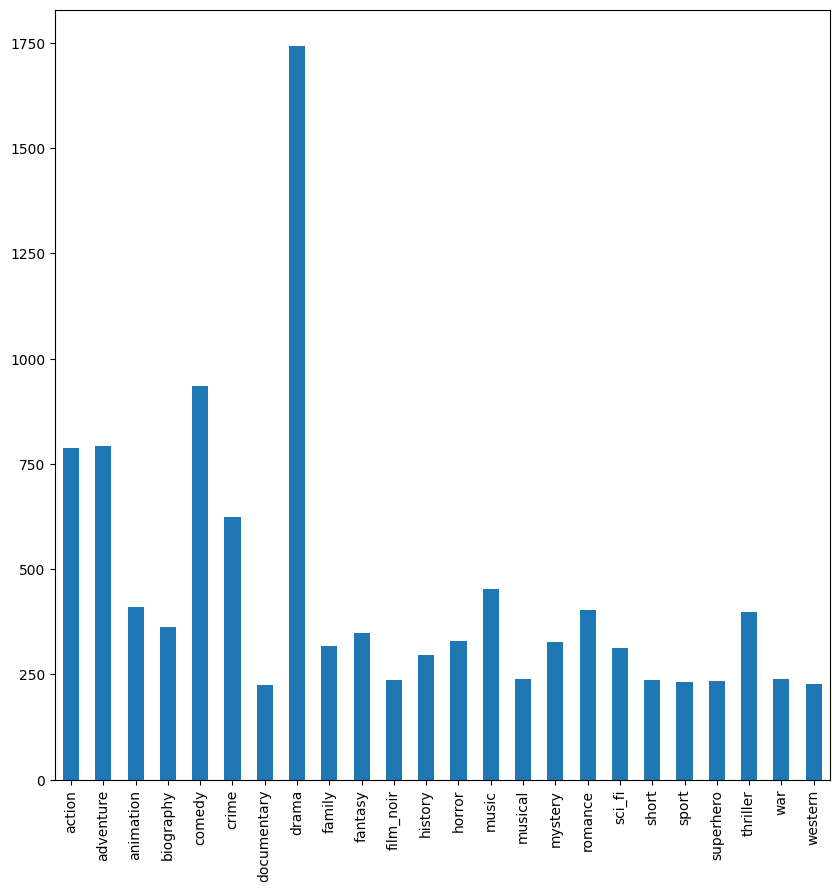

In [29]:
train_y.sum().plot.bar(figsize=(10,10))

<AxesSubplot: >

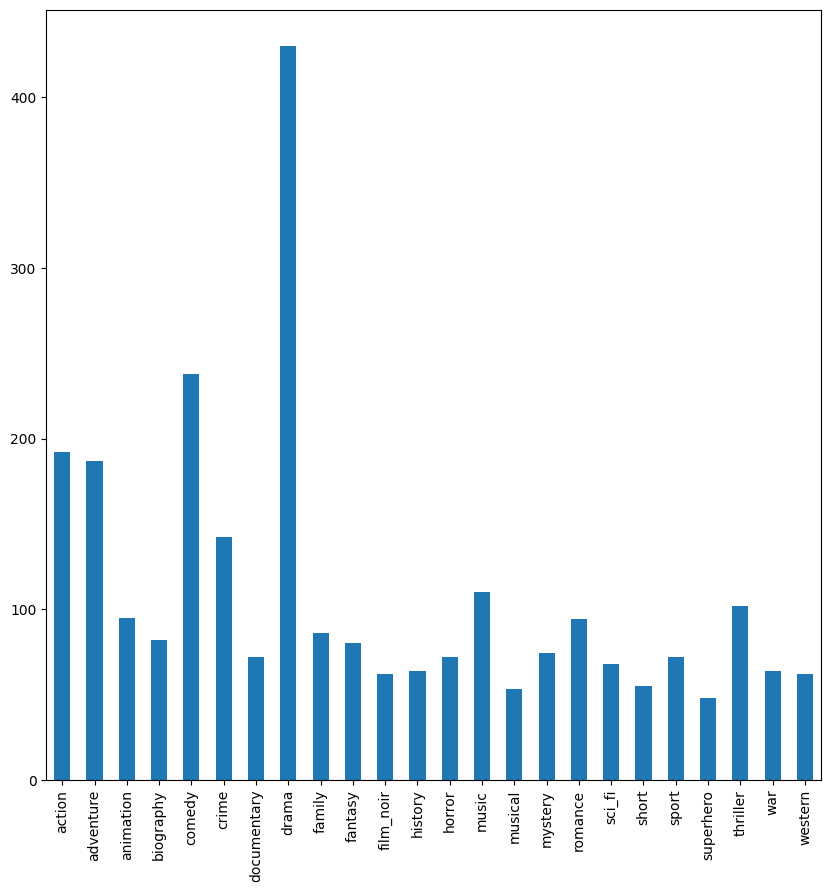

In [30]:
test_y.sum().plot.bar(figsize=(10,10))

# Let's create catboost classifier with optuna

In [31]:
def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["MultiLogloss", "MultiCrossEntropy"]),
        "n_estimators": trial.suggest_int("n_estimators", 5, 1000),
        "depth": trial.suggest_int("depth", 1, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.0001, 0.1),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "random_strength": trial.suggest_float("random_strength",1, 10),
        "random_seed": 2022,
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(test_x, test_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(test_x)
    F1_score = f1_score(test_y, preds, average='weighted')
    return F1_score


In [24]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=100))
study.optimize(objective, n_jobs=-1) # two hours

[I 2022-11-24 00:56:52,140] A new study created in memory with name: no-name-68ea89a5-90e4-4356-a53b-f1600bcb25c1
/home/dmitrypogrebnoy/Desktop/IndustrialML_ITMO/venv/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
[I 2022-11-24 00:59:09,846] Trial 1 finished with value: 0.2631921721849414 and parameters: {'objective': 'MultiLogloss', 'n_estimators': 771, 'depth': 1, 'learning_rate': 0.015387725868483729, 'l2_leaf_reg': 0.024250797970005986, 'bootstrap_type': 'Bernoulli', 'random_strength': 3.8572337287471745, 'subsample': 0.7098319590658771}. Best is trial 1 with value: 0.2631921721849414.
/home/dmitrypogrebnoy/Desktop/IndustrialML_ITMO/venv/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future vers

In [25]:
study.best_value

0.5474918831412887

In [26]:
study.best_params

{'objective': 'MultiLogloss',
 'n_estimators': 795,
 'depth': 3,
 'learning_rate': 0.09487592864294865,
 'l2_leaf_reg': 0.03280485852934037,
 'bootstrap_type': 'Bernoulli',
 'random_strength': 4.85420518990143,
 'subsample': 0.7385139010752287}

In [32]:
best_params = {'objective': 'MultiLogloss',
                 'n_estimators': 795,
                 'depth': 3,
                 'learning_rate': 0.09487592864294865,
                 'l2_leaf_reg': 0.03280485852934037,
                 'bootstrap_type': 'Bernoulli',
                 'random_strength': 4.85420518990143,
                 'subsample': 0.7385139010752287}

In [33]:
final_model = cb.CatBoostClassifier(**best_params)

In [34]:
final_model.fit(train_x, train_y, eval_set=[(test_x, test_y)], verbose=0, early_stopping_rounds=100)

/home/dmitrypogrebnoy/Desktop/IndustrialML_ITMO/venv/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [35]:
preds = final_model.predict(test_x)

/home/dmitrypogrebnoy/Desktop/IndustrialML_ITMO/venv/lib/python3.9/site-packages/catboost/core.py:1419: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [36]:
preds

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [37]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.71      0.45      0.55       192
           1       0.66      0.44      0.53       187
           2       0.56      0.29      0.39        95
           3       0.52      0.20      0.28        82
           4       0.63      0.43      0.51       238
           5       0.70      0.51      0.59       142
           6       0.74      0.32      0.45        72
           7       0.69      0.76      0.72       430
           8       0.56      0.12      0.19        86
           9       0.39      0.14      0.20        80
          10       0.75      0.19      0.31        62
          11       0.62      0.28      0.39        64
          12       0.63      0.26      0.37        72
          13       0.65      0.45      0.53       110
          14       0.50      0.21      0.29        53
          15       0.29      0.03      0.05        74
          16       0.62      0.16      0.25        94
          17       0.59    

/home/dmitrypogrebnoy/Desktop/IndustrialML_ITMO/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmitrypogrebnoy/Desktop/IndustrialML_ITMO/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
report_dict = classification_report(test_y, preds, output_dict=True)
report_dict

/home/dmitrypogrebnoy/Desktop/IndustrialML_ITMO/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/dmitrypogrebnoy/Desktop/IndustrialML_ITMO/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'precision': 0.7131147540983607,
  'recall': 0.453125,
  'f1-score': 0.554140127388535,
  'support': 192},
 '1': {'precision': 0.6587301587301587,
  'recall': 0.44385026737967914,
  'f1-score': 0.5303514376996805,
  'support': 187},
 '2': {'precision': 0.56,
  'recall': 0.29473684210526313,
  'f1-score': 0.3862068965517241,
  'support': 95},
 '3': {'precision': 0.5161290322580645,
  'recall': 0.1951219512195122,
  'f1-score': 0.28318584070796465,
  'support': 82},
 '4': {'precision': 0.6296296296296297,
  'recall': 0.42857142857142855,
  'f1-score': 0.51,
  'support': 238},
 '5': {'precision': 0.7019230769230769,
  'recall': 0.5140845070422535,
  'f1-score': 0.5934959349593496,
  'support': 142},
 '6': {'precision': 0.7419354838709677,
  'recall': 0.3194444444444444,
  'f1-score': 0.4466019417475728,
  'support': 72},
 '7': {'precision': 0.6913319238900634,
  'recall': 0.7604651162790698,
  'f1-score': 0.724252491694352,
  'support': 430},
 '8': {'precision': 0.5555555555555556,

In [39]:
f1_scores = [report_dict[f"{i}"]["f1-score"] for i in range(0, 24)]
f1_scores

[0.554140127388535,
 0.5303514376996805,
 0.3862068965517241,
 0.28318584070796465,
 0.51,
 0.5934959349593496,
 0.4466019417475728,
 0.724252491694352,
 0.19230769230769232,
 0.20370370370370372,
 0.30769230769230765,
 0.3870967741935484,
 0.37254901960784315,
 0.5297297297297298,
 0.2933333333333334,
 0.04938271604938272,
 0.2542372881355932,
 0.28888888888888886,
 0.0,
 0.7213114754098361,
 0.1754385964912281,
 0.05454545454545454,
 0.5631067961165049,
 0.6666666666666667]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, 'action'),
  Text(1, 0, 'adventure'),
  Text(2, 0, 'animation'),
  Text(3, 0, 'biography'),
  Text(4, 0, 'comedy'),
  Text(5, 0, 'crime'),
  Text(6, 0, 'documentary'),
  Text(7, 0, 'drama'),
  Text(8, 0, 'family'),
  Text(9, 0, 'fantasy'),
  Text(10, 0, 'film_noir'),
  Text(11, 0, 'history'),
  Text(12, 0, 'horror'),
  Text(13, 0, 'music'),
  Text(14, 0, 'musical'),
  Text(15, 0, 'mystery'),
  Text(16, 0, 'romance'),
  Text(17, 0, 'sci_fi'),
  Text(18, 0, 'short'),
  Text(19, 0, 'sport'),
  Text(20, 0, 'superhero'),
  Text(21, 0, 'thriller'),
  Text(22, 0, 'war'),
  Text(23, 0, 'western')])

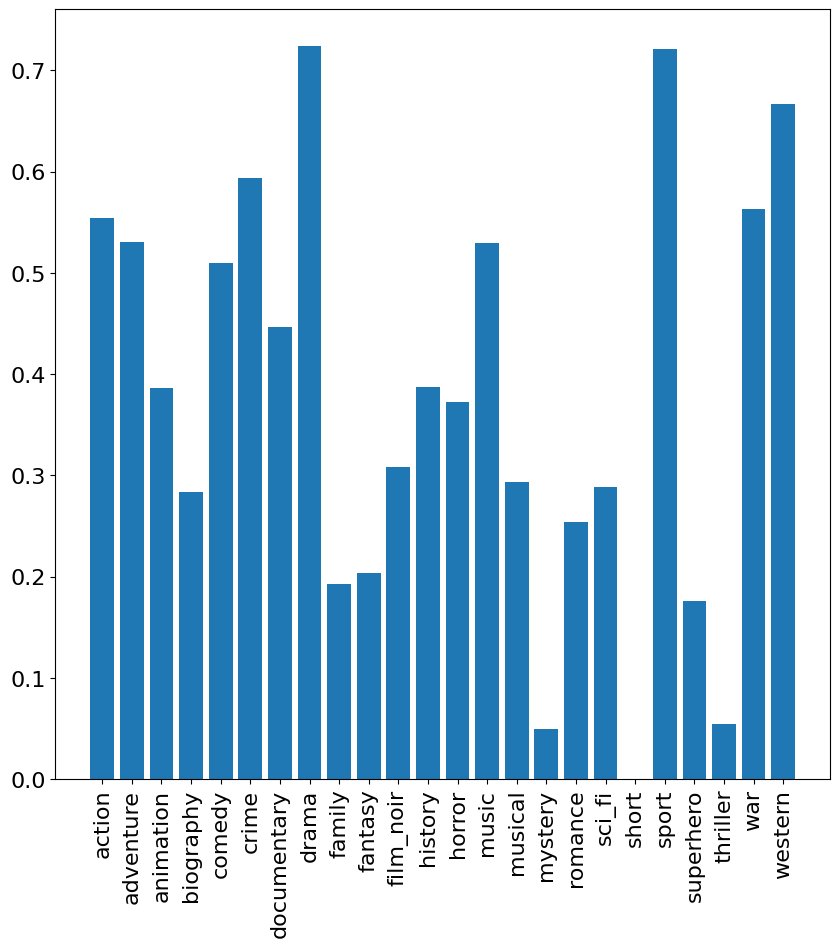

In [40]:
plt.rc('font', size=16)
plt.figure(figsize=(10,10))
plt.bar(np.arange(24), f1_scores, tick_label = CATEGORIES)
plt.xticks(rotation='vertical')

In [41]:
cm = multilabel_confusion_matrix(test_y, preds)
cm

array([[[607,  35],
        [105,  87]],

       [[604,  43],
        [104,  83]],

       [[717,  22],
        [ 67,  28]],

       [[737,  15],
        [ 66,  16]],

       [[536,  60],
        [136, 102]],

       [[661,  31],
        [ 69,  73]],

       [[754,   8],
        [ 49,  23]],

       [[258, 146],
        [103, 327]],

       [[740,   8],
        [ 76,  10]],

       [[737,  17],
        [ 69,  11]],

       [[768,   4],
        [ 50,  12]],

       [[759,  11],
        [ 46,  18]],

       [[751,  11],
        [ 53,  19]],

       [[698,  26],
        [ 61,  49]],

       [[770,  11],
        [ 42,  11]],

       [[755,   5],
        [ 72,   2]],

       [[731,   9],
        [ 79,  15]],

       [[757,   9],
        [ 55,  13]],

       [[779,   0],
        [ 55,   0]],

       [[756,   6],
        [ 28,  44]],

       [[782,   4],
        [ 43,   5]],

       [[727,   5],
        [ 99,   3]],

       [[760,  10],
        [ 35,  29]],

       [[764,   8],
        [ 27, 

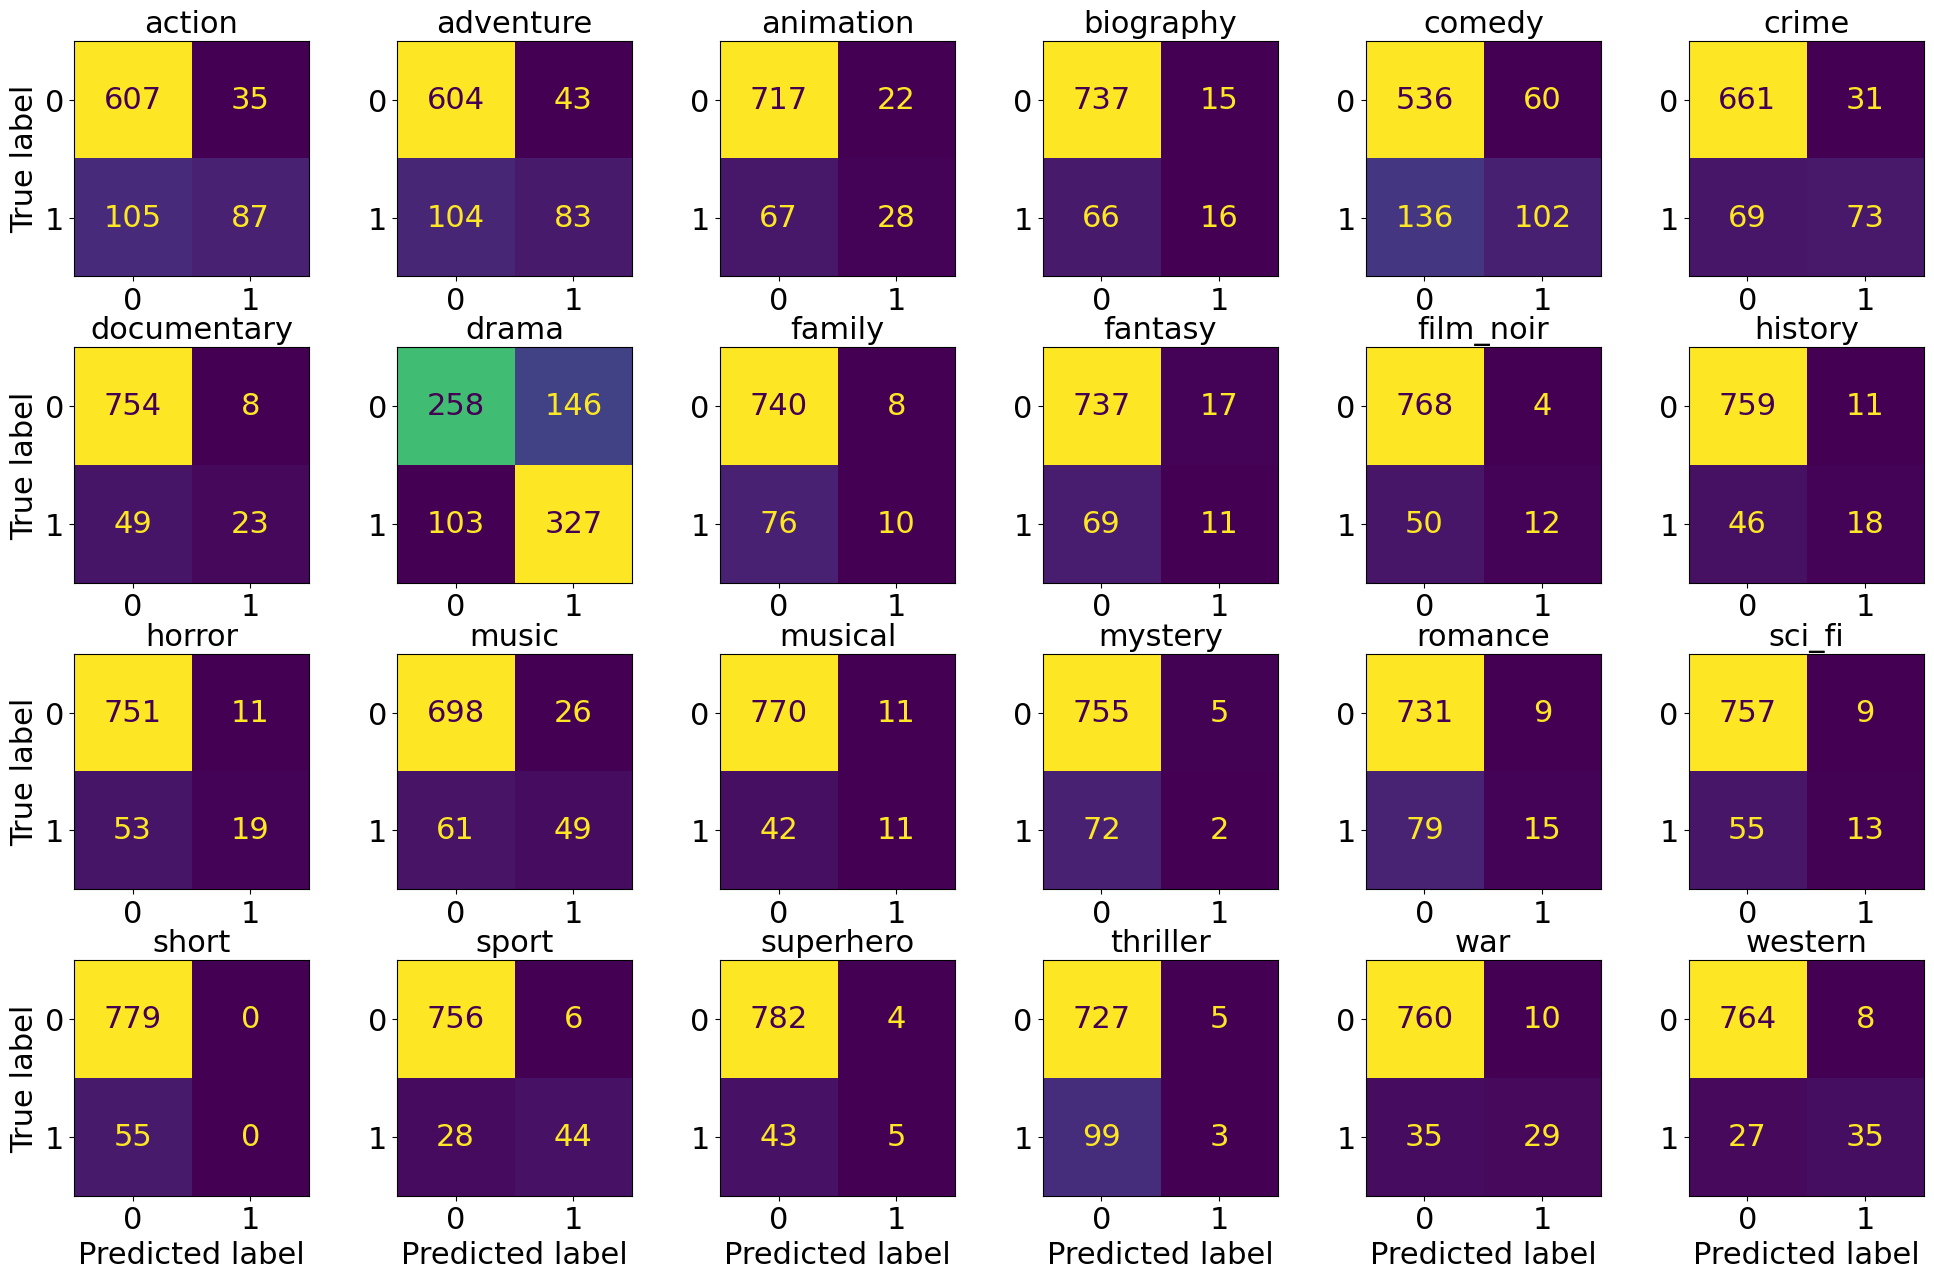

In [42]:
plt.rc('font', size=22)
f, axes = plt.subplots(4, 6, figsize=(25, 15))
axes = axes.ravel()
for i in range(24):
    disp = ConfusionMatrixDisplay(confusion_matrix(test_y.to_numpy()[:, i],
                                                   preds[:, i]))
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(CATEGORIES[i], fontdict={'size':'22'})
    if i<18:
        disp.ax_.set_xlabel('')
    if i%6!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.001, hspace=0.3)
plt.show()